In [1]:
import sim
import numpy as np
import sympy as sp
import pandas as pd
import time
import threading as thr
import keyboard
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import sklearn

In [ ]:
#print(f'Versión de sim: {sim.__version__}')
print(f'Versión de numpy: {np.__version__}')
print(f'Versión de sympy: {sp.__version__}')
print(f'Versión de pandas: {pd.__version__}')
#print(f'Versión de threading: {thr.__version__}')
#print(f'Versión de keyboard: {keyboard.__version__}')
print(f'Versión de matplotlib: {plt.matplotlib.__version__}')
print(f'Versión de TensorFlow: {tf.__version__}')
print(f'Versión de scikit-learn: {sklearn.__version__}')

------------------------------------Entrenamiento Modelo Inverso------------------------------------
Epoch 1/25
11/11 - 1s - loss: 1.8750 - val_loss: 1.1973 - 700ms/epoch - 64ms/step
Epoch 2/25
11/11 - 0s - loss: 1.1154 - val_loss: 0.7337 - 35ms/epoch - 3ms/step
Epoch 3/25
11/11 - 0s - loss: 0.6223 - val_loss: 0.5191 - 36ms/epoch - 3ms/step
Epoch 4/25
11/11 - 0s - loss: 0.3803 - val_loss: 0.4147 - 37ms/epoch - 3ms/step
Epoch 5/25
11/11 - 0s - loss: 0.2781 - val_loss: 0.3278 - 38ms/epoch - 3ms/step
Epoch 6/25
11/11 - 0s - loss: 0.2274 - val_loss: 0.2594 - 36ms/epoch - 3ms/step
Epoch 7/25
11/11 - 0s - loss: 0.2004 - val_loss: 0.2173 - 37ms/epoch - 3ms/step
Epoch 8/25
11/11 - 0s - loss: 0.1737 - val_loss: 0.1943 - 37ms/epoch - 3ms/step
Epoch 9/25
11/11 - 0s - loss: 0.1529 - val_loss: 0.1726 - 36ms/epoch - 3ms/step
Epoch 10/25
11/11 - 0s - loss: 0.1331 - val_loss: 0.1514 - 35ms/epoch - 3ms/step
Epoch 11/25
11/11 - 0s - loss: 0.1136 - val_loss: 0.1276 - 35ms/epoch - 3ms/step
Epoch 12/25
11/

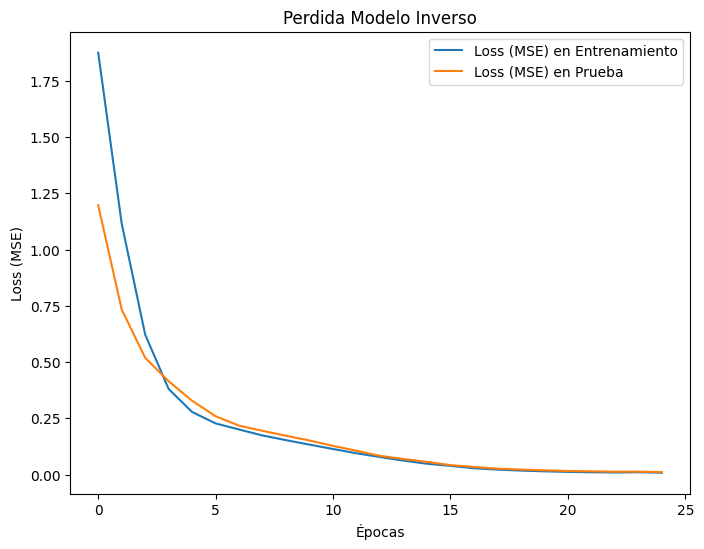

Error Cuadrático Medio (MSE) del Modelo Inverso: 0.01096617470737511
Coeficiente de Determinación (R^2) del Modelo Inverso: 0.9745296488010822


In [2]:

# Cargar el dataset
dataset = pd.read_csv('datos_entrenamiento2.csv')  # Asegúrate de reemplazar 'tu_dataset.csv' con el nombre de tu archivo
#dataset = pd.read_csv('datos_entrena.csv')  # Asegúrate de reemplazar 'tu_dataset.csv' con el nombre de tu archivo

######################################################################################################################

#                                       MODELO INVERSO

######################################################################################################################

# Dividir los datos en características (X) y etiquetas (y)
X = dataset[['PosX', 'PosY']].values
y = dataset[['Muslo', 'Rodilla']].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos (escalar)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo Inverso de Red Neuronal Artificial (RNA)
modeloInverso = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)  # Dos salidas para Muslo y Rodilla
])

# Compilar el modeloInverso
modeloInverso.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modeloInverso
print("------------------------------------Entrenamiento Modelo Inverso------------------------------------")
history = modeloInverso.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Realizar predicciones en el conjunto de prueba
y_pred = modeloInverso.predict(X_test)

# Evaluar el modeloInverso
mse_inv = mean_squared_error(y_test, y_pred)
r2_inv = r2_score(y_test, y_pred)


# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(8, 6)) 
plt.plot(history.history['loss'], label='Loss (MSE) en Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss (MSE) en Prueba')
plt.title('Perdida Modelo Inverso')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Error Cuadrático Medio (MSE) del Modelo Inverso: {mse_inv}")
print(f"Coeficiente de Determinación (R^2) del Modelo Inverso: {r2_inv}")




In [11]:

def connect(port):
# Establece la conexión a CoppeliaSim
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

# Conectarse al servidor de VREP
# *** ejecutar cada vez que se reinicia la simulación ***
clientID = connect(19999)

retCode,Dummy=sim.simxGetObjectHandle(clientID,'Dummy',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'joint2',sim.simx_opmode_blocking)

retCode,muslo1=sim.simxGetObjectHandle(clientID,'muslo1',sim.simx_opmode_blocking)
retCode,rodilla1=sim.simxGetObjectHandle(clientID,'rodilla1',sim.simx_opmode_blocking)

retCode,muslo2=sim.simxGetObjectHandle(clientID,'muslo2',sim.simx_opmode_blocking)
retCode,rodilla2=sim.simxGetObjectHandle(clientID,'rodilla2',sim.simx_opmode_blocking)

retCode,muslo3=sim.simxGetObjectHandle(clientID,'muslo3',sim.simx_opmode_blocking)
retCode,rodilla3=sim.simxGetObjectHandle(clientID,'rodilla3',sim.simx_opmode_blocking)

retCode,muslo4=sim.simxGetObjectHandle(clientID,'muslo4',sim.simx_opmode_blocking)
retCode,rodilla4=sim.simxGetObjectHandle(clientID,'rodilla4',sim.simx_opmode_blocking)

def BuscarInterserccion(center, radius, line_slope, line_intercept):
    a = 1 + line_slope**2
    b = -2 * center[0] + 2 * line_slope * (line_intercept - center[1])
    c = center[0]**2 + (line_intercept - center[1])**2 - radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return []  # No intersection points

    x1 = (-b + np.sqrt(discriminant)) / (2*a)
    x2 = (-b - np.sqrt(discriminant)) / (2*a)
    y1 = line_slope * x1 + line_intercept
    y2 = line_slope * x2 + line_intercept

    return [(x1, y1), (x2, y2)]

def CrearOvaloTrayectoriaCompleta(point1, point2, distancia_a_piso, frames, levantamiento_trayectoria):
    x1, y1 = point1
    x2, y2 = point2
    
    # Calcular el ancho y la altura utilizando los puntos dados
    if x1 > x2:
        width = x1*2
    elif x1 < x2:
        width = x2*2
    height = distancia_a_piso/5
    
    # Calcular el centro del óvalo
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    # Generar el óvalo utilizando las dimensiones calculadas
    theta = np.linspace(0, 2 * np.pi, frames)
    x = center_x + width/2 * np.cos(theta)
    y = center_y + height/2 * np.sin(theta)
    return x, y

def Get_Mov(largo_extremidad, altura_actual, Frames, levantamiento_trayectoria):
    # Parámetros de la circunferencia y la recta
    center = (0, 0)
    radius = largo_extremidad * 2
    line_slope = 0
    #altura_actual = 0.3

    # Encontrar puntos de intersección
    intersection_points = BuscarInterserccion(center, radius, line_slope, altura_actual)

    # Puntos que definen el óvalo
    point1 = intersection_points[0]
    point2 = intersection_points[1]

    # Crear el óvalo que pasa por los puntos dados
    #                                               , altura)
    x, y = CrearOvaloTrayectoriaCompleta(point1, point2, altura_actual, Frames, levantamiento_trayectoria)

    mov_x = []
    mov_y = []
    for i in range(len(y)):
        if y[i] <= altura_actual: # Si es menor que la distancia del robot al piso se puede elevar la pata
            mov_x.append(x[i])
            mov_y.append(y[i])

    #--------------------------------------------------------
    #
    #       aGREGAR EL ARRASTE, LA LINEA RECTA
    #
    #--------------------------------------------------------

    
    mitad = len(mov_y) // 2
    
    aux1 = [altura_actual for i in range(len(mov_y))]

    aux1 = aux1[mitad:]
    aux1_1 = aux1[:mitad]
    
    # Elimina el primer elemento del arreglo para evitar un mal comportamiento
    mov_y = mov_y[1:]
    mov_y = aux1 + mov_y + aux1_1
    aux1 = np.linspace(mov_x[len(mov_x)-1], mov_x[1], len(mov_x))
    
    # Asocia la mitad del arraste, para antes y despues de la trayectoria
    aux2 = aux1[:mitad]
    aux3 = aux1[mitad:]
    
    # Elimina el primer elemento del arreglo para evitar un mal comportamiento
    mov_x = mov_x[1:]
    mov_x = np.concatenate((aux3,mov_x))
    mov_x = np.concatenate((mov_x,aux2))
    #print("largo de MOV_X = ", len(mov_x))
    #print("largo de MOV_Y = ", len(mov_y))
    mov_y = [y - levantamiento_trayectoria for y in mov_y]
    return mov_x, mov_y

def GraficarTrayectoria(mov_x,mov_y):
    theta = np.linspace(0, np.pi, 100)
    radius = 0.4
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    # Dibujar el semicírculo

    plt.figure(figsize=(8, 6))  # Tamaño del gráfico
    plt.plot(mov_x,mov_y, 'ro', label='Trayectoria')  # Grupo 1 en rojo ('ro')
    plt.plot(x, y, 'g-', label='Alcance del extremo')
    plt.plot(0, 0, 'co', label='Muslo')

    # Convertir coordenadas polares a coordenadas cartesianas
    x = 0.2 * np.cos(theta)
    y = 0.2  * np.sin(theta)

    # Trasladar el semicírculo a la posición deseada
    x += 0.2  # Ajusta la posición en el eje x según tus necesidades
    y +=  0 # Ajusta la posición en el eje y según tus necesidades

    
    plt.fill(x, y, color='black', label='Fuera de alcance')
    plt.xlabel('Y')  # Etiqueta eje X
    plt.ylabel('X')  # Etiqueta eje Y
    plt.title('Coordenadas Juntas')  # Título del gráfico
    plt.legend()  # Mostrar leyenda

    plt.xlim(-0.4, 0.4)
    plt.ylim(-0.4, 0.4)

    """ plt.gca().invert_xaxis()  # Invertir eje X """
    plt.gca().invert_yaxis()  # Invertir eje Y 
    # Muestra el gráfico
    plt.grid(True)  # Agregar cuadrícula
    plt.show()
    
def PredecirAngulos(mov_x, mov_y,modelo):
    coordenadas = list(zip(mov_y, mov_x))  # 
    # Normalizar las coordenadas utilizando el mismo scaler que se usó durante el entrenamiento
    coordenadas_normalizadas = scaler.transform(coordenadas)
    prediccion = modelo.predict(coordenadas_normalizadas)
    muslos_datos = prediccion[:, 0] # Muslo
    rodillas_datos = prediccion[:, 1] # Rodilla

    # Para restarle los 90° que molestan, de dejar bien
    #muslos_datos -= 1.5
    
    return muslos_datos,rodillas_datos

def PredecirPosicion(ang_x, ang_y,modelo):
    angulos = [[ang_y, ang_x]]  # 
    # Normalizar las coordenadas utilizando el mismo scaler que se usó durante el entrenamiento
    angulos_normalizados = scaler.transform(angulos)
    prediccion = modelo.predict(angulos_normalizados)
    x = prediccion[:, 0] # Muslo
    y = prediccion[:, 1] # Rodilla

    # Para restarle los 90° que molestan, de dejar bien
    #muslos_datos -= 1.5
    
    return x,y

def MoverBrazoPiso(x_values,y_values):
    if len(x_values) == len(y_values):
        for i in range(len(x_values)):
            retCode = sim.simxSetJointTargetPosition(clientID, joint1, x_values[i], sim.simx_opmode_oneshot) # Muslo
            retCode = sim.simxSetJointTargetPosition(clientID, joint2, y_values[i], sim.simx_opmode_oneshot) # Rodilla
            time.sleep(0.001) #delay entre cada movimiento ejemplo: 0.001
    else:
        print("La longitud de los arreglos no coinciden")
        
import time
tiempo_promedio = 0.0

def Pierna_Delantera_Izquierda(mov_muslo,mov_rodilla, velocidad):
    global tiempo_promedio
    total_time1 = 0.0
    for i in range(len(mov_muslo)):
        start_time1 = time.time()  
        retCode = sim.simxSetJointTargetPosition(
            clientID, muslo1, mov_muslo[i], sim.simx_opmode_oneshot
        )
        retCode = sim.simxSetJointTargetPosition(
            clientID, rodilla1, mov_rodilla[i], sim.simx_opmode_oneshot
        )
        time.sleep(0.001)  
        end_time1 = time.time()  
        elapsed_time1 = end_time1 - start_time1 
        total_time1 += elapsed_time1 
    
    tiempo_promedio = total_time1 / len(mov_muslo)  # Calcula el tiempo promedio por ciclo
    """ print(f"Tiempo promedio por ciclo en Pierna Delantera Izquierda: {tiempo_promedio1} segundos") """


def Pierna_Delantera_Derecha(mov_muslo,mov_rodilla, velocidad):
    global tiempo_promedio
    total_time2 = 0.0  # Inicializa el tiempo total en 0.0 segundos
    for i in range(len(mov_muslo)):
        start_time2 = time.time()  
        retCode = sim.simxSetJointTargetPosition(
            clientID, muslo4, mov_muslo[i], sim.simx_opmode_oneshot
        )
        retCode = sim.simxSetJointTargetPosition(
            clientID, rodilla4, mov_rodilla[i], sim.simx_opmode_oneshot
        )
        time.sleep(0.001)  
        end_time2 = time.time()  
        elapsed_time2 = end_time2 - start_time2 
        total_time2 += elapsed_time2 
    
    tiempo_promedio = total_time2 / len(mov_muslo)  # Calcula el tiempo promedio por ciclo
    """ print(f"Tiempo promedio por ciclo en Pierna Delantera Derecha: {tiempo_promedio2} segundos") """


def Pierna_Tracera_Izquierda(mov_muslo, mov_rodilla, velocidad):
    global tiempo_promedio
    total_time3 = 0.0  

    for i in range(len(mov_muslo)):
        start_time3 = time.time()  
        retCode = sim.simxSetJointTargetPosition(
            clientID, muslo2, mov_muslo[i], sim.simx_opmode_oneshot
        )
        retCode = sim.simxSetJointTargetPosition(
            clientID, rodilla2, mov_rodilla[i], sim.simx_opmode_oneshot
        )
        time.sleep(0.001)
        end_time3 = time.time()
        elapsed_time3 = end_time3 - start_time3  
        total_time3 += elapsed_time3 
    
    tiempo_promedio = total_time3 / len(mov_muslo)  # Calcula el tiempo promedio por ciclo
    """ print(f"Tiempo promedio por ciclo en Pierna Tracera Izquierda: {tiempo_promedio3} segundos") """


def Pierna_Tracera_Derecha(mov_muslo,mov_rodilla, velocidad):
    global tiempo_promedio
    total_time4 = 0.0  
    for i in range(len(mov_muslo)):
        start_time4 = time.time()  
        retCode = sim.simxSetJointTargetPosition(
            clientID, muslo3, mov_muslo[i], sim.simx_opmode_oneshot
        )
        retCode = sim.simxSetJointTargetPosition(
            clientID, rodilla3, mov_rodilla[i], sim.simx_opmode_oneshot
        )
        time.sleep(0.001)  # delay entre cada movimiento ejemplo: 0.001
        end_time4 = time.time()  # Registra el tiempo de finalización del ciclo
        elapsed_time4 = end_time4 - start_time4  # Calcula el tiempo de ejecución del ciclo
        total_time4 += elapsed_time4  # Agrega el tiempo del ciclo al tiempo total
    
    tiempo_promedio = total_time4 / len(mov_muslo)  # Calcula el tiempo promedio por ciclo
    """ print(f"Tiempo promedio por ciclo en Pierna Tracera Derecha: {tiempo_promedio4} segundos") """
    

import threading
import keyboard

def Avance(muslos_data,rodilla_data,velocidad):
    hilo1 = thr.Thread(target=Pierna_Delantera_Izquierda, args=(muslos_data,rodilla_data,0))
    hilo2 = thr.Thread(target=Pierna_Delantera_Derecha, args=(muslos_data,rodilla_data,0))
    hilo3 = thr.Thread(target=Pierna_Tracera_Izquierda, args=(muslos_data,rodilla_data,0))
    hilo4 = thr.Thread(target=Pierna_Tracera_Derecha, args=(muslos_data,rodilla_data,0))

    hilo2.start()
    hilo3.start()
    time.sleep(round(tiempo_promedio, 5)* (len(muslos_data)/2))
    #time.sleep(0.7)
    hilo1.start()
    hilo4.start()

    hilo2.join()
    hilo3.join()
    hilo1.join()
    hilo4.join()
    
    
    
def Retroceso(muslos_data,rodilla_data,velocidad):
    muslos_data = muslos_data[::-1]
    rodilla_data = rodilla_data[::-1]
    
    hilo1 = thr.Thread(target=Pierna_Delantera_Izquierda, args=(muslos_data,rodilla_data,0))
    hilo2 = thr.Thread(target=Pierna_Delantera_Derecha, args=(muslos_data,rodilla_data,0))
    hilo3 = thr.Thread(target=Pierna_Tracera_Izquierda, args=(muslos_data,rodilla_data,0))
    hilo4 = thr.Thread(target=Pierna_Tracera_Derecha, args=(muslos_data,rodilla_data,0))

    hilo2.start()
    hilo3.start()
    time.sleep(round(tiempo_promedio, 5)* (len(muslos_data)/2))
    #time.sleep(0.7)
    hilo1.start()
    hilo4.start()

    hilo2.join()
    hilo3.join()
    hilo1.join()
    hilo4.join()
    
def Sentarse():
    res, muslo_get = sim.simxGetJointPosition(clientID, muslo2, sim.simx_opmode_blocking)
    res, rodilla_get = sim.simxGetJointPosition(clientID, rodilla2, sim.simx_opmode_blocking)
    
    time.sleep(0.1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, muslo_get, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, rodilla_get, sim.simx_opmode_oneshot)
    time.sleep(0.1)

    res, dummy_posicion = sim.simxGetObjectPosition(clientID, Dummy, -1, sim.simx_opmode_blocking)
    dummy_posicion_truncada = [round(coord, 4) for coord in dummy_posicion]
    
    x, y, z = dummy_posicion_truncada
    agachado = [0.15 , 0]
    x_values = np.linspace(x, agachado[0], 100)
    y_values = np.linspace(y, agachado[1], 100)
    
    muslos_datos_sentarse , rodillas_datos_sentarse = PredecirAngulos(y_values, x_values,modeloInverso)

    hilo1 = thr.Thread(target=Pierna_Delantera_Izquierda, args=(muslos_datos_sentarse,rodillas_datos_sentarse,0))
    hilo2 = thr.Thread(target=Pierna_Delantera_Derecha, args=(muslos_datos_sentarse,rodillas_datos_sentarse,0))
    hilo3 = thr.Thread(target=Pierna_Tracera_Izquierda, args=(muslos_datos_sentarse,rodillas_datos_sentarse,0))
    hilo4 = thr.Thread(target=Pierna_Tracera_Derecha, args=(muslos_datos_sentarse,rodillas_datos_sentarse,0))
    hilo4.start()
    hilo3.start()
    hilo3.join()
    hilo4.join()
    
def PosicionInicial(movX,movY,velocidad):
    
    destino = [movX[0] , movY[0]]
    
    res, muslo_get = sim.simxGetJointPosition(clientID, muslo2, sim.simx_opmode_blocking)
    res, rodilla_get = sim.simxGetJointPosition(clientID, rodilla2, sim.simx_opmode_blocking)
    time.sleep(0.1)

    retCode = sim.simxSetJointTargetPosition(clientID, joint1, muslo_get, sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, rodilla_get, sim.simx_opmode_oneshot)
    time.sleep(0.1)
    res, dummy_position = sim.simxGetObjectPosition(clientID, Dummy, -1, sim.simx_opmode_blocking)
    dummy_position_truncated = [round(coord, 4) for coord in dummy_position]
    # Separar las coordenadas en variables individuales
    x, y, z = dummy_position_truncated
    x_values = np.linspace(x, destino[0], 100)
    y_values = np.linspace(y, destino[1], 100)
    
    muslos_datos_inicio , rodillas_datos_inicio = PredecirAngulos(y_values, x_values,modeloInverso)
    
    hilo1 = thr.Thread(target=Pierna_Delantera_Izquierda, args=(muslos_datos_inicio,rodillas_datos_inicio,0))
    hilo2 = thr.Thread(target=Pierna_Delantera_Derecha, args=(muslos_datos_inicio,rodillas_datos_inicio,0))
    hilo3 = thr.Thread(target=Pierna_Tracera_Izquierda, args=(muslos_datos_inicio,rodillas_datos_inicio,0))
    hilo4 = thr.Thread(target=Pierna_Tracera_Derecha, args=(muslos_datos_inicio,rodillas_datos_inicio,0))

    hilo2.start()
    hilo3.start()
    hilo1.start()
    hilo4.start()

    hilo2.join()
    hilo3.join()
    hilo1.join()
    hilo4.join()  

conectado a 19999


In [12]:
# Get_Mov = largo_extremidad, altura_actual, Frames, levantamiento_trayectori
mov_x , mov_y = Get_Mov(0.2,0.39,100,0.15)
#GraficarTrayectoria(mov_x,mov_y)
muslos_datos , rodillas_datos = PredecirAngulos(mov_x, mov_y,modeloInverso)
#MoverBrazoPiso(muslos_datos,rodillas_datos)

PosicionInicial(mov_y,mov_x,0)
while True:
    if keyboard.is_pressed('w'):
        Avance(muslos_datos,rodillas_datos,0)
    
    if keyboard.is_pressed('s'):
        Retroceso(muslos_datos,rodillas_datos,0)
        
    if keyboard.is_pressed('i'):
        PosicionInicial(mov_y,mov_x,0)
        
    if keyboard.is_pressed('o'):
        Sentarse()

    if keyboard.is_pressed('esc'):
        print("Espero que le haya gustado :D.")
        break 


4/4 [==============================] - 0s 1ms/step


In [6]:
coordenadas = list(zip(mov_y, mov_x))  # 
# Normalizar las coordenadas utilizando el mismo scaler que se usó durante el entrenamiento
coordenadas_normalizadas = scaler.transform(coordenadas)
prediccion = modeloInverso.predict(coordenadas_normalizadas)

4/4 [==============================] - 0s 1ms/step


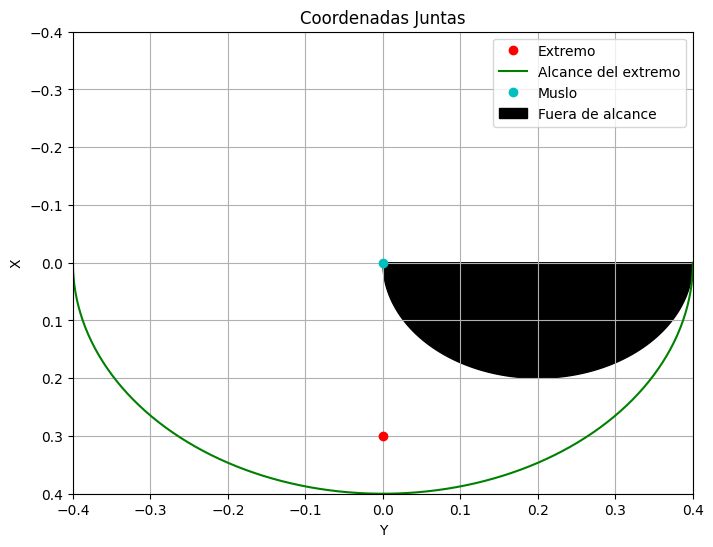

In [24]:
mov_x = 0
mov_y = 0.3

theta = np.linspace(0, np.pi, 100)
radius = 0.4
x = radius * np.cos(theta)
y = radius * np.sin(theta)

# Dibujar el semicírculo
plt.figure(figsize=(8, 6))  # Tamaño del gráfico
plt.plot(mov_x,mov_y, 'ro', label='Extremo')  # Grupo 1 en rojo ('ro')
plt.plot(x, y, 'g-', label='Alcance del extremo')
plt.plot(0, 0, 'co', label='Muslo')

# Convertir coordenadas polares a coordenadas cartesianas
x = 0.2 * np.cos(theta)
y = 0.2  * np.sin(theta)
# Trasladar el semicírculo a la posición deseada
x += 0.2  # Ajusta la posición en el eje x según tus necesidades
y +=  0 # Ajusta la posición en el eje y según tus necesidades
# Graficar el semicírculo en color purpura

plt.fill(x, y, color='black', label='Fuera de alcance')
plt.xlabel('Y')  # Etiqueta eje X
plt.ylabel('X')  # Etiqueta eje Y
plt.title('Coordenadas Juntas')  # Título del gráfico
plt.legend()  # Mostrar leyenda
plt.xlim(-0.4, 0.4)
plt.ylim(-0.4, 0.4)

plt.gca().invert_yaxis()  # Invertir eje Y 
# Muestra el gráfico
plt.grid(True)  # Agregar cuadrícula
plt.show()

In [7]:
x_values = prediccion[:, 0] # Muslo
y_values = prediccion[:, 1] # Rodilla

# Para restarle los 90° que molestan, de dajr bien
x_values -= 1.5

In [13]:
for i in range(len(x_values)):
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, x_values[i], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, y_values[i], sim.simx_opmode_oneshot)
    time.sleep(0.001) #delay entre cada movimiento ejemplo: 0.001